# Итоговый f_score на Kaggle = 0.98937

In [0]:
# !pip install -U torch torchvision

In [0]:
# !pip uninstall -y Pillow
# !pip install -U albumentations
# !pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [0]:
# установка подходящей версии torch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import random

random.seed(27)
np.random.seed(27)
torch.manual_seed(27)
torch.cuda.manual_seed(27)
torch.backends.cudnn.deterministic = True

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive_msu/')

In [0]:
!unzip -q /content/gdrive_msu/My\ Drive/Simpsons/data/dataset.zip -d train 
!unzip -q /content/gdrive_msu/My\ Drive/Simpsons/data/testset.zip -d test

In [0]:
!nvidia-smi
torch.cuda.is_available()
torch.cuda.empty_cache()

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = {
            'val': transforms.Compose([
                transforms.Resize((244, 244)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], 
                                     [0.229, 0.224, 0.225]) 
            ]),
            'test': transforms.Compose([
                transforms.Resize((244, 244)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], 
                                     [0.229, 0.224, 0.225]) 
            ]),
            'train': transforms.Compose([
                transforms.Resize((244, 244)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], 
                                     [0.229, 0.224, 0.225])
            ])
        }
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
            x = transform['test'](x)
            return x
        elif self.mode == 'val':
            x = transform['val'](x)
        else:
            x = transform['train'](x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

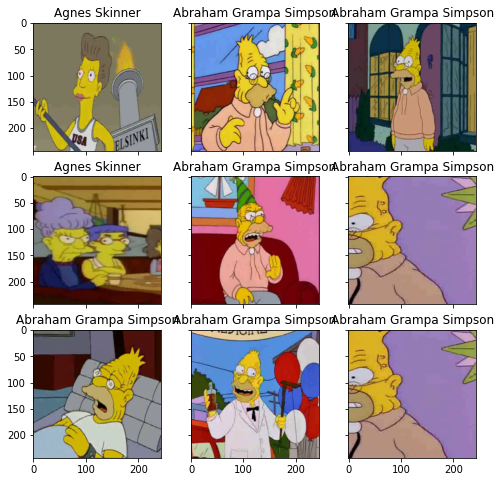

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, criterion, optimizer, epochs, batch_size, filename):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    dataloaders = {'train': train_loader, 'val': val_loader}

    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, dataloaders['train'], criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, dataloaders['val'], criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc > best_acc:
                print('    ____NEW BEST!!!____')
                best_acc = val_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(), f'{filename}.pth') 

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        
            # scheduler.step(val_loss)
        
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'resnet34.pth') 
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Описание работы
Используется resnet34 с размороженными последними тремя блоками.  
В ходе экспериментов выяснилось, что лучший результат дает такая архитектура с использованием CrossEntropyLoss и AdamW без scheduler (пробовал использовать StepLR и ReduceLROnPlateu).


In [0]:
n_classes = len(np.unique(train_val_labels))
model = models.resnet34(pretrained=True)

model.fc = nn.Linear(in_features=model.fc.in_features, out_features=n_classes)

for child in list(model.children())[:-3]:
    for param in child.parameters():
        param.requires_grad = False

model = model.to('cuda')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True)

In [0]:
history = train(train_files=train_dataset, val_files=val_dataset, model=model, \
                criterion=loss_fn, optimizer=optimizer, \
                epochs=20, batch_size=64, filename='resnet34')

In [0]:
model.load_state_dict(torch.load('resnet34.pth'))
model_save_name = 'resnet34_val_acc=9465.pth'
path = f"/content/gdrive_msu/My Drive/Simpsons/{model_save_name}" 
torch.save(model.state_dict(), path)

## Визуализация

In [0]:
model.load_state_dict(torch.load('resnet34.pth'))

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels = [label_encoder.classes_[i] for i in actual_labels]

In [0]:
from sklearn.metrics import f1_score

print(type(actual_labels[0]))
print(type(preds_class[0]))

f1_score(actual_labels, preds_class, average='weighted')

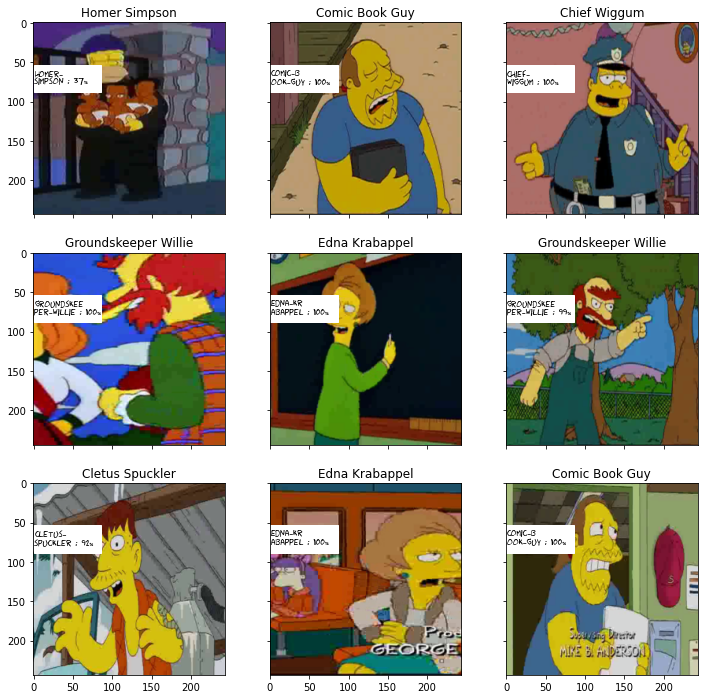

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(1000, 2000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
! ls 

In [0]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [0]:
my_submit.to_csv('/content/gdrive_msu/My Drive/Simpsons/resnet34_val_acc=9541.csv', index=False)